### **Import Libraries**

In [156]:
import pandas as pd
import numpy as np
import gc
import joblib

from typing import Tuple, List, Dict, Optional, Union, Callable, Any, Iterator

import optuna
from optuna.trial import Trial
from optuna.study import Study

from datetime import datetime
from typing import List

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### **Settings**

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### **Load Dataset**

In [3]:
train_path = r'D:\Project\Python\Portfolio\Big Data\[Bottleneck] CLS - Spring Leaf Markeing Response\data\train.csv'

df = pd.read_csv(train_path)
df.head()

C:\Users\msi.pc\AppData\Local\Temp\ipykernel_11372\2736376315.py:3: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_path)


,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,...,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [4]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (145231, 1934)


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.3 GB


In [6]:
def is_convertable_sr(col: pd.Series) -> bool:
  if col.dtype == np.int64 and\
      col.max() <= np.iinfo(np.int32).max and\
      col.min() >= np.iinfo(np.int32).min: return True
  
  if col.dtype == np.float64 and\
      col.max() <= np.finfo(np.float32).max and\
      col.min() >= np.finfo(np.float32).min: return True
  
  if np.isnan(col.max()): return True

  return False

def save_memory_df(df_origin: pd.DataFrame) -> pd.DataFrame:
  int_cols = df_origin.select_dtypes(np.int64).columns
  float_cols = df_origin.select_dtypes(np.float64).columns
  
  int_cols = [col for col in int_cols if is_convertable_sr(df_origin[col])]
  float_cols = [col for col in float_cols if is_convertable_sr(df_origin[col])]
  
  int_cols = {col: np.int32 for col in int_cols}
  float_cols = {col: np.float32 for col in float_cols}

  df_origin = df_origin.astype(int_cols)
  df_origin = df_origin.astype(float_cols)
  
  return df_origin

def save_memory_sr(sr_origin: pd.Series) -> pd.Series:
  if sr_origin.dtype == np.int64 and is_convertable_sr(sr_origin): sr_origin.astype(np.int32)
  if sr_origin.dtype == np.float64 and is_convertable_sr(sr_origin): sr_origin.astype(np.float32)
  
  return sr_origin

df = save_memory_df(df)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float32(477), int32(1406), object(51)
memory usage: 1.3 GB


### **EDA**

##### **A. Target value**

Ratio of target (1 and 0): 3.300210227104492


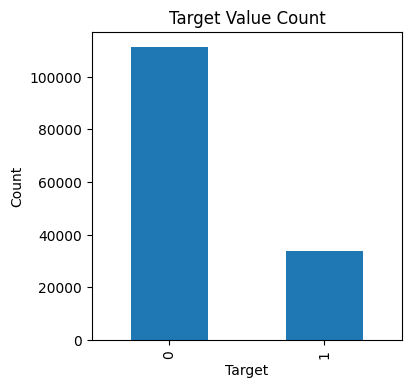

In [8]:
target_dist = df['target'].value_counts().sort_values(ascending=False)
target_dist.plot(kind='bar',
                 figsize=(4, 4),
                 title='Target Value Count',
                 xlabel='Target',
                 ylabel='Count')

mayor_minor_ratio = target_dist[0] / target_dist[1]
print(f'Ratio of target (1 and 0): {mayor_minor_ratio}')

##### **B. Missing value - column**

<Axes: title={'center': 'Top 50 of % of Missing Value vs Feature'}, xlabel='Feature', ylabel='% of Missing Value'>

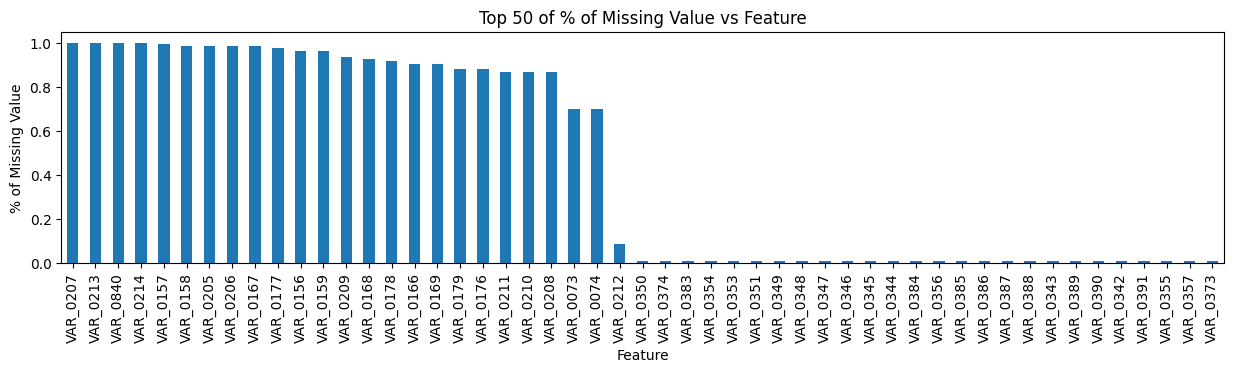

In [9]:
df_cols_null = df.isna().mean().sort_values(ascending=False).drop('target')

df_cols_null[:51].plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Top 50 of % of Missing Value vs Feature',
                       xlabel='Feature',
                       ylabel=r'% of Missing Value')

In [10]:
df_cols_null_70p = df_cols_null[df_cols_null > 0.69]
df_cols_null_70p = df_cols_null_70p.index.to_list()

print(f'Numbers of feature(s): {len(df_cols_null_70p)}\nFeatures: {df_cols_null_70p}')

Numbers of feature(s): 24
Features: ['VAR_0207', 'VAR_0213', 'VAR_0840', 'VAR_0214', 'VAR_0157', 'VAR_0158', 'VAR_0205', 'VAR_0206', 'VAR_0167', 'VAR_0177', 'VAR_0156', 'VAR_0159', 'VAR_0209', 'VAR_0168', 'VAR_0178', 'VAR_0166', 'VAR_0169', 'VAR_0179', 'VAR_0176', 'VAR_0211', 'VAR_0210', 'VAR_0208', 'VAR_0073', 'VAR_0074']


##### **C. Single unique value feature**

In [11]:
df_num_cols = df.select_dtypes(exclude='object').columns
df_cat_cols = df.select_dtypes('object').columns

print(f'Numbers of numerical feature(s): {len(df_num_cols)}')
print(f'Numbers of categorical feature(s): {len(df_cat_cols)}')

Numbers of numerical feature(s): 1883
Numbers of categorical feature(s): 51


<Axes: title={'center': 'Bottom 50 of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

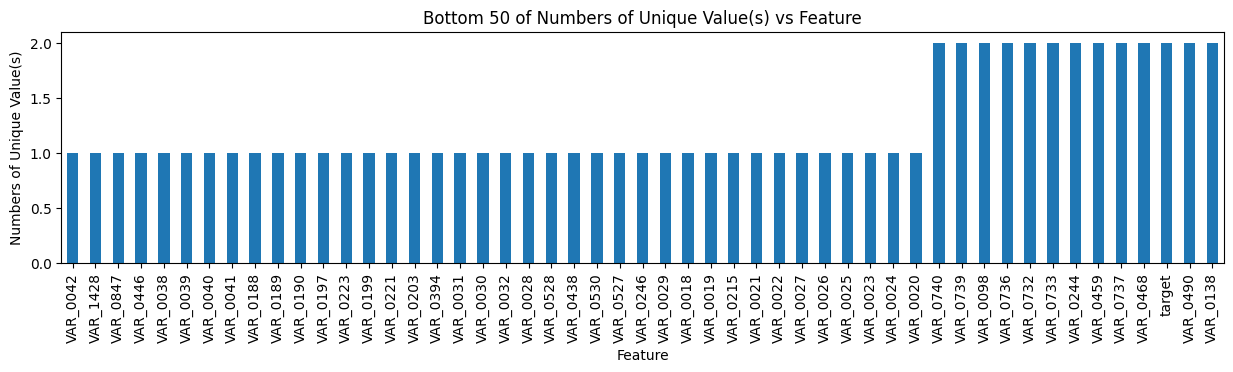

In [12]:
df_num_cols_low_var = df[df_num_cols].nunique().sort_values()
df_num_cols_low_var = df_num_cols_low_var[df_num_cols_low_var > 0][:51]
df_num_cols_low_var.plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Bottom 50 of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [13]:
df_num_cols_single = df_num_cols_low_var[df_num_cols_low_var == 1]
df_num_cols_single = df_num_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_num_cols_single)}\nFeatures: {df_num_cols_single}')

Numbers of feature(s): 38
Features: ['VAR_0042', 'VAR_1428', 'VAR_0847', 'VAR_0446', 'VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0188', 'VAR_0189', 'VAR_0190', 'VAR_0197', 'VAR_0223', 'VAR_0199', 'VAR_0221', 'VAR_0203', 'VAR_0394', 'VAR_0031', 'VAR_0030', 'VAR_0032', 'VAR_0028', 'VAR_0528', 'VAR_0438', 'VAR_0530', 'VAR_0527', 'VAR_0246', 'VAR_0029', 'VAR_0018', 'VAR_0019', 'VAR_0215', 'VAR_0021', 'VAR_0022', 'VAR_0027', 'VAR_0026', 'VAR_0025', 'VAR_0023', 'VAR_0024', 'VAR_0020']


<Axes: title={'center': 'Bottom of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

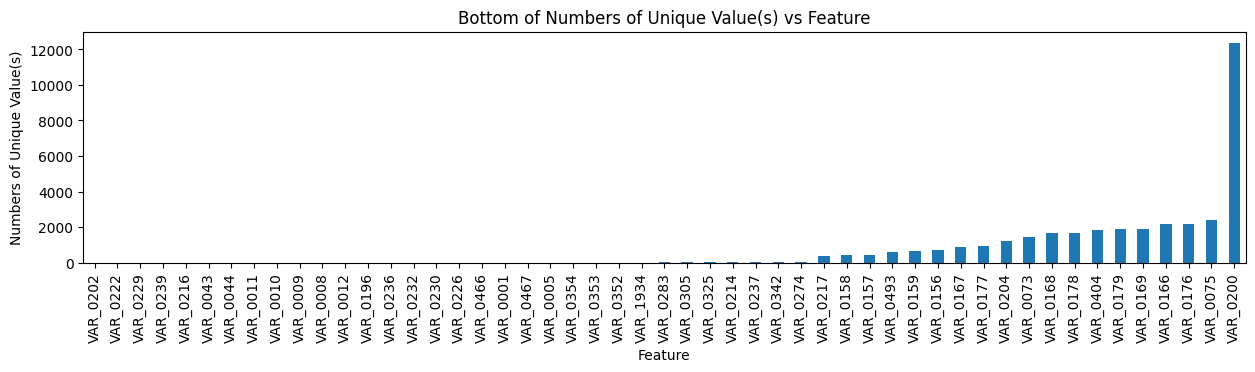

In [14]:
df_cat_cols_low_var = df[df_cat_cols].nunique().sort_values()
df_cat_cols_low_var = df_cat_cols_low_var[df_cat_cols_low_var > 0][:51]
df_cat_cols_low_var.plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Bottom of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [15]:
df_cat_cols_single = df_cat_cols_low_var[df_cat_cols_low_var == 1]
df_cat_cols_single = df_cat_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_cat_cols_single)}\nFeatures: {df_cat_cols_single}')

Numbers of feature(s): 13
Features: ['VAR_0202', 'VAR_0222', 'VAR_0229', 'VAR_0239', 'VAR_0216', 'VAR_0043', 'VAR_0044', 'VAR_0011', 'VAR_0010', 'VAR_0009', 'VAR_0008', 'VAR_0012', 'VAR_0196']


##### **D. Missing Value (rows)**

In [16]:
cols = df_cols_null_70p + df_num_cols_single + df_cat_cols_single
threshold_null = 0.2 + len(cols)/len(df)

row_null_count = df.isnull().mean(axis=1)
row_null_count = row_null_count[row_null_count > threshold_null]
df_row_null = row_null_count.index.to_list()

dr_row_null_target_dist = df.iloc[df_row_null]['target'].value_counts()

print(f'Threshold for missing features: {threshold_null}\n')
print(f'Instance(s):\n{row_null_count}\n')
print(f'Instance(s) target distribution: \n{dr_row_null_target_dist}\n')

Threshold for missing features: 0.2005164186709449

Instance(s):
9855      0.271458
11910     0.271458
13018     0.271458
13447     0.271458
16524     0.271458
17461     0.271458
20511     0.271458
25658     0.271458
27429     0.271458
33001     0.271458
36093     0.271458
36534     0.271458
40061     0.271458
40317     0.271458
40848     0.271458
41185     0.271458
43410     0.271458
43629     0.271458
45875     0.271458
55156     0.271458
56206     0.271458
57191     0.271458
58586     0.271458
60229     0.271458
62100     0.271458
62455     0.271458
65682     0.271458
66061     0.271458
70000     0.271458
79003     0.271458
79268     0.271458
84358     0.271458
85066     0.271458
87829     0.271458
88207     0.271458
91939     0.271458
94705     0.271458
94729     0.271458
96148     0.271458
97962     0.271458
105196    0.271458
112029    0.271458
115558    0.271458
117069    0.271458
122319    0.271458
122527    0.271458
124410    0.271458
133942    0.271458
135973    0.271458
1387

# **Approach 1 (Baseline)**

### **Feature engineering**

In [17]:
%%script skipped # Skipped for resource optimization

def convert_str2cat(df_origin: pd.DataFrame) -> pd.DataFrame:
  cat_cols = df_origin.select_dtypes('object').columns
  
  cat_cols = {col: 'category' for col in cat_cols}
  df_origin = df_origin.astype(cat_cols)
  
  return df_origin

df = convert_str2cat(df)

Couldn't find program: 'skipped'


### **Data splitting**

##### **A. Train - test data split**

In [18]:
%%script skipped # Skipped for resource optimization

X, X_test, y, y_test = train_test_split(df.drop(columns=['ID', 'target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['target'])

print(f'Train dataset shape (X): {X.shape}')
print(f'Test dataset shape (X_test): {X_test.shape}')

Couldn't find program: 'skipped'


##### **B. Data folding**

In [19]:
%%script skipped # Skipped for resource optimization

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Couldn't find program: 'skipped'


### **Model preparation**

In [20]:
%%script skipped # Skipped for resource optimization

classifier = LGBMClassifier(objective='binary', metric='auc', n_jobs=4)

Couldn't find program: 'skipped'


### **Model training**

In [21]:
%%script skipped # Skipped for resource optimization

X_num_cols = X.select_dtypes(exclude='category').columns
X_cat_cols = X.select_dtypes('category').columns

Couldn't find program: 'skipped'


In [22]:
%%script skipped # Skipped for resource optimization

auc_scores = np.zeros(n_splits)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
  classifier.fit(X_train, y_train, categorical_feature=X_cat_cols.to_list())
  
  y_probs = classifier.predict_proba(X_valid)[:, 1]
  
  auc = roc_auc_score(y_valid, y_probs)
  auc_scores[fold] = auc
  
  print(f'Fold {fold} => AUC score: {auc}')
  
mean_auc = np.mean(auc_scores)
print(f'Mean AUC oof score: {mean_auc:.4f}')

Couldn't find program: 'skipped'


In [23]:
%%script skipped # Skipped for resource optimization

df_feat_imp = pd.DataFrame({'Feature': classifier.feature_name_, 'Importance': classifier.feature_importances_})
df_feat_imp = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp[:50].plot(kind='bar',
                      x='Feature',
                      y='Importance',
                      title=f'Feature Importance LGBM default (AUC = {mean_auc:.4f})',
                      xlabel='Feature',
                      ylabel='Feature Importance',
                      figsize=(15, 3))

Couldn't find program: 'skipped'


In [24]:
%%script skipped # Skipped for resource optimization

top_feat_50 = df[df_feat_imp[:50]['Feature']]
top_feat_50.head()

Couldn't find program: 'skipped'


In [25]:
%%script skipped # Skipped for resource optimization

cat_feat = top_feat_50.select_dtypes('category').columns
num_feat = top_feat_50.select_dtypes(exclude='category').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Couldn't find program: 'skipped'


In [26]:
%%script skipped # Skipped for resource optimization

del df, X, X_test, y, y_train, n_splits, skf, classifier, X_num_cols, X_cat_cols, auc_scores, mean_auc, feature_importance_df, top_feat_50, cat_feat, num_feat
gc.collect()

Couldn't find program: 'skipped'


# **Approach 2**
Treat missing value as missing and perform imputation to fill the value.

In [27]:
%%script skipped # Skipped for resource optimization

df = pd.read_csv(train_path)
df = save_memory_df(df)

df.info(memory_usage='deep')

Couldn't find program: 'skipped'


### **Feature Engineering**

##### **A. Drop columns**

In [28]:
columns_to_drop = set(df_cols_null_70p + df_num_cols_single + df_cat_cols_single)
df.drop(columns=columns_to_drop, inplace=True)

print(f'Total dropped columns: {len(columns_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped columns: 75
Dataset shape: (145231, 1859)


##### **B. Drop duplicates**

In [29]:
df_duplicates = df.duplicated()
df.drop_duplicates(inplace=True, keep='first')

print(f'Numbers of duplicated in dataset: {df_duplicates.sum()}')

Numbers of duplicated in dataset: 0


##### **C. Drop rows**

In [30]:
rows_to_drop = df_row_null
df.drop(index=rows_to_drop, axis=0, inplace=True)

print(f'Total dropped rows: {len(rows_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped rows: 53
Dataset shape: (145178, 1859)


##### **D. Categorical data**

In [31]:
df_cat_cols_new = df.select_dtypes('object').columns
df[df_cat_cols_new].head()

,VAR_0001,VAR_0005,VAR_0075,VAR_0200,VAR_0204,VAR_0217,VAR_0226,VAR_0230,VAR_0232,VAR_0236,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
0,H,C,08NOV11:00:00:00,FT LAUDERDALE,29JAN14:21:16:00,08NOV11:02:00:00,False,False,True,True,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
1,H,B,10NOV11:00:00:00,SANTEE,01FEB14:00:11:00,02OCT12:02:00:00,False,False,False,True,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
2,H,C,13DEC11:00:00:00,REEDSVILLE,30JAN14:15:11:00,13DEC11:02:00:00,False,False,True,True,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
3,H,C,23SEP10:00:00:00,LIBERTY,01FEB14:00:07:00,01NOV12:02:00:00,False,False,False,True,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
4,R,N,15OCT11:00:00:00,FRANKFORT,29JAN14:19:31:00,15OCT11:02:00:00,False,False,True,True,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [32]:
df[df_cat_cols_new].nunique().sort_values(ascending=False)

VAR_0200    12385
VAR_0075     2371
VAR_0404     1823
VAR_0204     1192
VAR_0493      608
VAR_0217      397
VAR_0274       57
VAR_0342       50
VAR_0237       45
VAR_0325        9
VAR_0305        8
VAR_0283        7
VAR_1934        5
VAR_0005        4
VAR_0352        4
VAR_0353        4
VAR_0354        4
VAR_0467        4
VAR_0001        3
VAR_0236        2
VAR_0232        2
VAR_0230        2
VAR_0466        2
VAR_0226        2
dtype: int64

In [33]:
def parse_str2time(df_origin: pd.DataFrame, cols: list, date_format, drop=False):
  for _, col in enumerate(cols):
    parsed_date = pd.to_datetime(df_origin[col], format=date_format)

    df_origin[f'{col}_DAY'] = parsed_date.dt.day
    df_origin[f'{col}_MONTH'] = parsed_date.dt.month
    df_origin[f'{col}_YEAR'] = parsed_date.dt.month
    
    df_origin[f'{col}_HOUR'] = parsed_date.dt.hour
    df_origin[f'{col}_MIN'] = parsed_date.dt.minute
    
    if drop:
      df_origin.drop(columns=[col], inplace=True)
    
  return df_origin

In [34]:
date_format = '%d%b%y:%H:%M:%S'
date_cols = ['VAR_0075', 'VAR_0204', 'VAR_0217']

df = parse_str2time(df_origin=df,
                    cols=date_cols,
                    date_format=date_format,
                    drop=True)
df = save_memory_df(df)

In [35]:
display(df.filter(like='VAR_0075').head())
display(df.filter(like='VAR_0204').head())
display(df.filter(like='VAR_0217').head())

,VAR_0075_DAY,VAR_0075_MONTH,VAR_0075_YEAR,VAR_0075_HOUR,VAR_0075_MIN
0,8.0,11.0,11.0,0.0,0.0
1,10.0,11.0,11.0,0.0,0.0
2,13.0,12.0,12.0,0.0,0.0
3,23.0,9.0,9.0,0.0,0.0
4,15.0,10.0,10.0,0.0,0.0


,VAR_0204_DAY,VAR_0204_MONTH,VAR_0204_YEAR,VAR_0204_HOUR,VAR_0204_MIN
0,29.0,1.0,1.0,21.0,16.0
1,1.0,2.0,2.0,0.0,11.0
2,30.0,1.0,1.0,15.0,11.0
3,1.0,2.0,2.0,0.0,7.0
4,29.0,1.0,1.0,19.0,31.0


,VAR_0217_DAY,VAR_0217_MONTH,VAR_0217_YEAR,VAR_0217_HOUR,VAR_0217_MIN
0,8.0,11.0,11.0,2.0,0.0
1,2.0,10.0,10.0,2.0,0.0
2,13.0,12.0,12.0,2.0,0.0
3,1.0,11.0,11.0,2.0,0.0
4,15.0,10.0,10.0,2.0,0.0


In [36]:
parsed_date_cols = ['VAR_0075_DAY', 'VAR_0075_MONTH', 'VAR_0075_YEAR', 'VAR_0075_HOUR', 'VAR_0075_MIN',
                    'VAR_0204_DAY', 'VAR_0204_MONTH', 'VAR_0204_YEAR', 'VAR_0204_HOUR', 'VAR_0204_MIN',
                    'VAR_0217_DAY', 'VAR_0217_MONTH', 'VAR_0217_YEAR', 'VAR_0217_HOUR', 'VAR_0217_MIN']

parsed_date_cols_single = df[parsed_date_cols].nunique().sort_values()
parsed_date_cols_single

VAR_0075_HOUR      1
VAR_0075_MIN       1
VAR_0217_HOUR      1
VAR_0217_MIN       1
VAR_0204_MONTH     2
VAR_0204_YEAR      2
VAR_0204_DAY       4
VAR_0075_MONTH    12
VAR_0075_YEAR     12
VAR_0204_HOUR     12
VAR_0217_MONTH    12
VAR_0217_YEAR     12
VAR_0075_DAY      31
VAR_0217_DAY      31
VAR_0204_MIN      60
dtype: int64

In [37]:
parsed_date_cols_single = parsed_date_cols_single[parsed_date_cols_single == 1]
parsed_date_cols_single = parsed_date_cols_single.index.to_list()
parsed_date_cols_single

['VAR_0075_HOUR', 'VAR_0075_MIN', 'VAR_0217_HOUR', 'VAR_0217_MIN']

In [38]:
df.drop(columns=parsed_date_cols_single, axis=1, inplace=True)

In [39]:
df_cat_cols_new = df.select_dtypes('object').columns
df[df_cat_cols_new].head()

,VAR_0001,VAR_0005,VAR_0200,VAR_0226,VAR_0230,VAR_0232,VAR_0236,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
0,H,C,FT LAUDERDALE,False,False,True,True,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
1,H,B,SANTEE,False,False,False,True,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
2,H,C,REEDSVILLE,False,False,True,True,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
3,H,C,LIBERTY,False,False,False,True,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
4,R,N,FRANKFORT,False,False,True,True,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [40]:
df[df_cat_cols_new].nunique().sort_values(ascending=False)

VAR_0200    12385
VAR_0404     1823
VAR_0493      608
VAR_0274       57
VAR_0342       50
VAR_0237       45
VAR_0325        9
VAR_0305        8
VAR_0283        7
VAR_1934        5
VAR_0005        4
VAR_0352        4
VAR_0353        4
VAR_0354        4
VAR_0467        4
VAR_0001        3
VAR_0236        2
VAR_0232        2
VAR_0230        2
VAR_0466        2
VAR_0226        2
dtype: int64

In [41]:
var200_count = df['VAR_0200'].value_counts()
var200_count[var200_count >= 20]

VAR_0200
CHICAGO         2091
HOUSTON         1306
JACKSONVILLE    1063
SAN ANTONIO     1012
INDIANAPOLIS     866
                ... 
HAINES CITY       20
SAN FERNANDO      20
WILDOMAR          20
RED LION          20
CARMICHAEL        20
Name: count, Length: 1426, dtype: int64

In [42]:
var200_count.filter(like='PHILA')

VAR_0200
PHILADELPHIA        772
PHILA                75
NEW PHILADELPHIA      9
NEW PHILA             7
PHILADELHIA           4
PHILADEPHIA           3
PHILADLEPHIA          1
PHILAELPHIA           1
PHILADELPHIIA         1
PHILAD                1
PHILADELPHA           1
PHILADEPLHIA          1
PHILADELPIA           1
Name: count, dtype: int64

In [43]:
var404_count = df['VAR_0404'].value_counts()
var404_count[var404_count >= 20]

VAR_0404
-1                               130443
CONTACT                            2163
PRESIDENT                          1315
AGENT                              1072
DIRECTOR                            864
OWNER                               770
MEMBER                              566
SECRETARY                           512
INDIVIDUAL - SOLE OWNER             458
MANAGER                             361
INCORPORATOR                        288
VICE PRESIDENT                      267
CONTA                               254
TREASURER                           225
BOARD MEMBER                        167
MEMBER MANAGER                      164
CEO                                 143
OFFICE MANAGER                      106
REGISTRANT                          105
CHIEF EXECUTIVE OFFICER             103
MANAGING MEMBER                     102
TAX RESPONSIBLE PARTY                99
PARTNER                              88
CFO                                  87
ORGANIZER                      

In [44]:
var404_count.filter(like='PRESIDENT')

VAR_0404
PRESIDENT                              1315
VICE PRESIDENT                          267
PRESIDENT, DIRECTOR                      12
VICE-PRESIDENT                           12
DIRECTOR;PRESIDENT                        9
                                       ... 
PRESIDENT,TREASURER                       1
DIRECTOR,VICE PRESIDENT                   1
VICE PRESIDENT, REAL ESTATE               1
DIRECTOR,PRESIDENT,SECRETARY,TREASU       1
EXECUTIVE VICE PRESIDENT, ADVERTISI       1
Name: count, Length: 107, dtype: int64

In [45]:
var493_count = df['VAR_0493'].value_counts()
var493_count[var493_count >= 20]

VAR_0493
-1                                      135182
REGISTERED NURSE                          1099
LICENSED PRACTICAL NURSE                   767
PHARMACY TECHNICIAN                        536
COSMETOLOGIST                              452
GUARD                                      399
PERMANENT EMPLOYEE REGISTRATION CARD       325
PROFESSIONAL NURSE                         246
LICENSED VOCATIONAL NURSE                  243
NURSE AIDE                                 238
CERTIFIED NURSING ASSISTANT                238
REAL ESTATE                                226
PRACTICAL NURSE                            141
CERTIFIED NURSE AIDE                       111
INSURANCE AGENTS                            98
LICENSED REAL ESTATE SALESPERSON            89
REGISTERED PROFESSIONAL NURSE               86
FIREARM PERMIT                              85
MASTER COSMETOLOGIST                        79
REAL ESTATE SALESPERSON                     75
RN                                          70
VOCA

In [46]:
var493_count.filter(like='TECHNICIAN')

VAR_0493
PHARMACY TECHNICIAN                 536
EMERGENCY MEDICAL TECHNICIAN         62
PSYCHIATRIC TECHNICIAN               22
NAIL TECHNICIAN                      19
NAIL TECHNICIANS                     14
SMOG CHECK ADVANCED TECHNICIAN        7
REGISTERED VETERINARY TECHNICIAN      5
VETERINARY TECHNICIAN                 2
RESPIRATORY THERAPY TECHNICIAN        2
CARDIAC TECHNICIAN                    2
PHARMACEUTICAL TECHNICIAN             1
VETERINARY ANIMAL TECHNICIAN          1
MEDICAL RESPONSE TECHNICIAN           1
ANIMAL HEALTH TECHNICIAN              1
NAIL TECHNICIAN APPRENTICE            1
SOCIAL WORK TECHNICIAN                1
NON-CERTIFIED TECHNICIAN              1
CERTIFIED EUTHANASIA TECHNICIAN       1
Name: count, dtype: int64

### **Data splitting**

##### **A. Train - test data split**

In [47]:
X, X_test, y, y_test = train_test_split(df.drop(columns=['ID', 'target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['target'])

print(f'Train dataset shape (X): {X.shape}')
print(f'Test dataset shape (X_test): {X_test.shape}')

Train dataset shape (X): (116142, 1865)
Test dataset shape (X_test): (29036, 1865)


##### **B. Data folding**

In [48]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **Data preprocessing**

In [49]:
X_num_cols = X.select_dtypes(exclude='object').columns
X_cat_cols = X.select_dtypes('object').columns

##### **A. Taget encoding**

In [68]:
def target_encoding(y_tr_origin: np.ndarray, y_ts_origin: np.ndarray, encoder):
  y_tr_enc = encoder.fit_transform(y_tr_origin)
  y_ts_enc = encoder.transform(y_ts_origin)
  
  return (y_tr_enc, y_ts_enc)

##### **B. Imbalanced data**

In [67]:
def resampling(X_tr_origin: np.ndarray, y_tr_origin: np.ndarray, sampler):
  X_res, y_res = sampler.fit_resample(X_tr_origin, y_tr_origin)
  
  return (X_res, y_res)

##### **C. Outlier**

In [66]:
def remove_outliers(X_tr_origin: np.ndarray, y_tr_origin: np.ndarray, outlier_detector):
  outlier_label = outlier_detector.fit_predict(X_tr_origin)
  non_outlier_mask = outlier_label == 1
  
  X_tr_clean = X_tr_origin[non_outlier_mask]
  y_tr_clean = y_tr_origin[non_outlier_mask]
  
  return (X_tr_clean, y_tr_clean)

##### **D. Save memory**

In [121]:
def save_memory(_data: List[np.ndarray]):
  _data = [data.astype(np.float32) if data.dtype == np.float64 else data.astype(np.int32) for data in _data]
  
  return _data

##### **E. Build pipeline**

In [231]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_scaler = RobustScaler()

cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_encoder = OrdinalEncoder(dtype=np.float32,
                             handle_unknown='use_encoded_value',
                             unknown_value=-2,
                             encoded_missing_value=-1,
                             min_frequency=10)
cat_scaler = RobustScaler()

outlier_detector = IsolationForest(random_state=42, n_jobs=4, contamination=0.01)
sampler = RandomUnderSampler(random_state=42)

label_encoder = LabelEncoder()

num_preprocessor_pipe = Pipeline([
  ('imputer', num_imputer),
  ('scaler', num_scaler)
])

cat_preprocessor_pipe = Pipeline([
  ('imputer', cat_imputer),
  ('encoder', cat_encoder),
  ('scaler', cat_scaler)
])

preprocessor_pipe = ColumnTransformer(
  transformers=[
    ('num', num_preprocessor_pipe, X_num_cols.to_list()),
    ('cat', cat_preprocessor_pipe, X_cat_cols.to_list())
  ]
)

def preprocessor(X_tr, X_ts, y_tr, y_ts):
  X_tr_pre, X_ts_pre, y_tr_pre, y_ts_pre = X_tr, X_ts, y_tr, y_ts
  
  X_tr_pre = preprocessor_pipe.fit_transform(X_tr_pre)
  X_ts_pre = preprocessor_pipe.transform(X_ts_pre)
  
  # X_tr_pre, y_tr_pre = remove_outliers(X_tr_pre, y_tr_pre, outlier_detector)
  y_tr_pre, y_ts_pre = target_encoding(y_tr_pre, y_ts_pre, label_encoder)
  X_tr_pre, y_tr_pre = resampling(X_tr_pre, y_tr_pre, sampler)
  
  X_tr_pre, X_ts_pre, y_tr_pre, y_ts_pre = save_memory([X_tr_pre, X_ts_pre, y_tr_pre, y_ts_pre])
  
  return [X_tr_pre, X_ts_pre, y_tr_pre, y_ts_pre]

### **Model Selection**

In [219]:
def train_model(
  X: pd.DataFrame,
  y: pd.Series,
  model: BaseEstimator,
  preprocessor: Callable[..., List[Union[float, int]]],
  scorer: Callable,
  cv_fold,
  skip_fold: Optional[str]=None,
  cb_fold: Optional[Callable]=None,
  cb_end: Optional[Callable]=None
) -> Tuple[float, float]:
  auc_scores_train = []
  auc_scores_valid = []
  
  is_odd = int(skip_fold == 'odd')
  trunc_cv_fold = cv_fold.split(X, y) if not skip_fold else [item for i, (item) in enumerate(cv_fold.split(X, y)) if i % 2 == is_odd]
  
  for fold, (train_idx, valid_idx) in enumerate(trunc_cv_fold):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    X_train, X_valid, y_train, y_valid = preprocessor(X_train, X_valid, y_train, y_valid)
    
    model.fit(X_train, y_train)
    
    y_probs_train = model.predict_proba(X_train)[:, 1]
    y_probs_val = model.predict_proba(X_valid)[:, 1]
    
    auc_train = scorer(y_train, y_probs_train)
    auc_valid = scorer(y_valid, y_probs_val)
    
    auc_scores_train.append(auc_train)
    auc_scores_valid.append(auc_valid)
    
    if cb_fold: cb_fold(fold, (auc_train, auc_valid))
    
  mean_auc_train = np.mean(auc_scores_train)
  mean_auc_val = np.mean(auc_scores_valid)
  
  if cb_end: cb_end((mean_auc_train, mean_auc_val))

  return (auc_scores_train, auc_scores_valid)

### **LGBM Classifier**

##### **A. Default LGBMClassifier**

In [216]:
%%script skipped # Skipped for resource optimization

clf_lgbm_default = LGBMClassifier(objective='binary', boosting_type='gbdt', metric='auc', n_jobs=4, verbosity=-1)

In [220]:
%%script skipped # Skipped for resource optimization

cb_fold = lambda fold, scores: print(f'Fold {fold + 1} => AUC score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')
cb_end = lambda scores: print(f'Mean AUC oof score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')

auc_scores_train, auc_scores_valid = train_model(X, y,
                                                model=clf_lgbm_default,
                                                preprocessor=preprocessor,
                                                scorer=roc_auc_score,
                                                cv_fold=skf,
                                                cb_fold=cb_fold,
                                                cb_end=cb_end)
mean_auc_train, mean_auc_val = np.mean(auc_scores_train), np.mean(auc_scores_valid)

Fold 1 => AUC score: 0.8374 (train) | 0.7779 (valid)
Fold 2 => AUC score: 0.8371 (train) | 0.7753 (valid)
Mean AUC oof score: 0.8373 (train) | 0.7766 (valid)


<Axes: title={'center': 'Feature Importance LGBM-Default (AUC = 0.7766)'}, xlabel='Feature', ylabel='Feature Importance'>

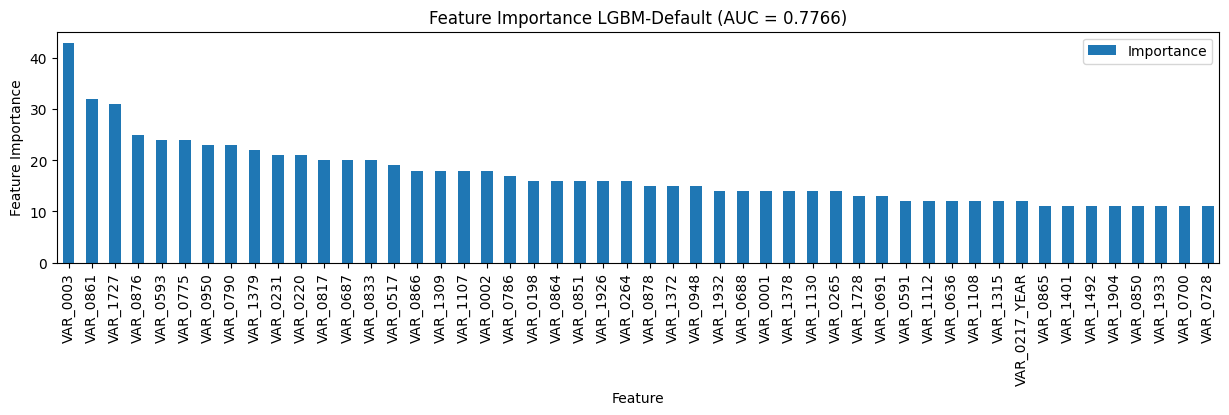

In [218]:
%%script skipped # Skipped for resource optimization

df_feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': clf_lgbm_default.feature_importances_})
df_feat_imp = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp[:50].plot(kind='bar',
                      x='Feature',
                      y='Importance',
                      title=f'Feature Importance LGBM-Default (AUC = {mean_auc_val:.4f})',
                      xlabel='Feature',
                      ylabel='Feature Importance',
                      figsize=(15, 3))

In [131]:
%%script skipped # Skipped for resource optimization

top_feat_50 = df[df_feat_imp[:50]['Feature']]

cat_feat = top_feat_50.select_dtypes('object').columns
num_feat = top_feat_50.select_dtypes(exclude='object').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Numbers of categorical feature(s): 1
Numbers of numerical feature(s): 49


In [134]:
%%script skipped # Skipped for resource optimization

y_preds = clf_lgbm_default.predict_proba(preprocessor_pipe.transform(X_test))[:, 1]
clf_lgbm_def_auc_test = roc_auc_score(y_test, y_preds)

print(f'AUC score of test dataset: {clf_lgbm_def_auc_test:.4f}')

AUC score of test dataset: 0.7802


##### **B. Tuned LGBMClassifier**

In [234]:
%%script skipped # Skipped for resource optimization

defined_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': 4,
    'verbosity': -1,
    'random_seed': 42
  }

def objective(trial: Trial):
  tuned_params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 150),
    'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
    'num_leaves': trial.suggest_int('num_leaves', 20, 64),
    'max_depth': trial.suggest_int('max_depth', 20, 128),
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 32),
    'subsample': trial.suggest_float('subsample', 0.4, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True)
  }
  
  clf_lgbm_tuned = LGBMClassifier(**defined_params, **tuned_params)
    
  auc_scores_train, auc_scores_valid = train_model(X, y,
                                                  model=clf_lgbm_tuned,
                                                  preprocessor=preprocessor,
                                                  scorer=roc_auc_score,
                                                  cv_fold=skf,
                                                  skip_fold='odd')
  mean_auc_train, mean_auc_valid = np.mean(auc_scores_train), np.mean(auc_scores_valid)

  print(f'Mean AUC oof score (n={trial.number}): {mean_auc_train:.4f} (train) | {mean_auc_valid:.4f} (valid)')
  
  return mean_auc_valid

def callback(study: Study, trial: Trial):
  joblib.dump(study, 'clf_lgbm_study.pkl')

Couldn't find program: 'skipped'


In [136]:
%%script skipped # Skipped for resource optimization

try:
  study = joblib.load('clf_lgbm_study.pkl')
except FileNotFoundError:
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=50, n_jobs=2, callbacks=[callback])

In [137]:
%%script skipped # Skipped for resource optimization

best_params = study.best_params
best_params

{'n_estimators': 113,
 'learning_rate': 0.07414738508726511,
 'num_leaves': 64,
 'max_depth': 128,
 'min_child_samples': 26,
 'subsample': 0.4088981384627649,
 'colsample_bytree': 0.4649739607621698,
 'reg_alpha': 0.00289556487927133,
 'reg_lambda': 0.8929633543221254}

In [138]:
%%script skipped # Skipped for resource optimization

optuna.visualization.plot_param_importances(study)

In [147]:
%%script skipped # Skipped for resource optimization

optuna.visualization.plot_slice(study, params=list(best_params.keys()))

In [140]:
%%script skipped # Skipped for resource optimization

clf_lgbm_tuned = LGBMClassifier(**defined_params, **best_params)

In [141]:
%%script skipped # Skipped for resource optimization

cb_epoch = lambda fold, scores: print(f'Fold {fold + 1} => AUC score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')
cb_end = lambda scores: print(f'Mean AUC oof score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')

auc_scores_train, auc_scores_valid = train_model(X, y,
                                                model=clf_lgbm_tuned,
                                                preprocessor=preprocessor,
                                                scorer=roc_auc_score,
                                                cv_fold=skf,
                                                cb_epoch=cb_epoch,
                                                cb_end=cb_end)
mean_auc_train, mean_auc_val = np.mean(auc_scores_train), np.mean(auc_scores_valid)

Fold 1 => AUC score: 0.8672 (train) | 0.7858 (valid)
Fold 2 => AUC score: 0.8672 (train) | 0.7790 (valid)
Fold 3 => AUC score: 0.8678 (train) | 0.7775 (valid)
Fold 4 => AUC score: 0.8678 (train) | 0.7780 (valid)
Fold 5 => AUC score: 0.8669 (train) | 0.7828 (valid)
Mean AUC oof score: 0.8674 (train) | 0.7806 (valid)


<Axes: title={'center': 'Feature Importance Tunned LGBM (AUC = 0.7806)'}, xlabel='Feature', ylabel='Feature Importance'>

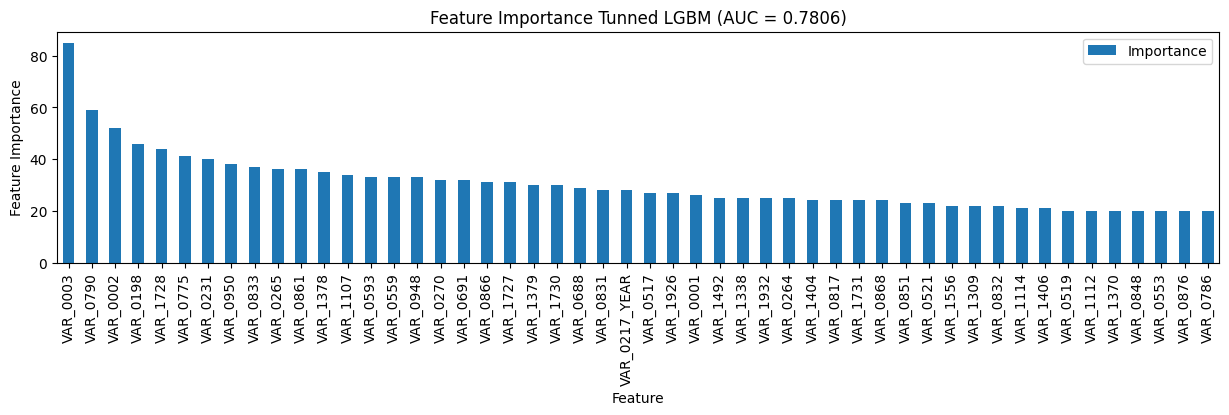

In [143]:
%%script skipped # Skipped for resource optimization

df_feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': clf_lgbm_tuned.feature_importances_})
df_feat_imp = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp[:50].plot(kind='bar',
                      x='Feature',
                      y='Importance',
                      title=f'Feature Importance LGBM-Tuned (AUC = {mean_auc_val:.4f})',
                      xlabel='Feature',
                      ylabel='Feature Importance',
                      figsize=(15, 3))

In [144]:
%%script skipped # Skipped for resource optimization

top_feat_50 = df[df_feat_imp[:50]['Feature']]

cat_feat = top_feat_50.select_dtypes('object').columns
num_feat = top_feat_50.select_dtypes(exclude='object').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Numbers of categorical feature(s): 1
Numbers of numerical feature(s): 49


In [145]:
%%script skipped # Skipped for resource optimization

y_preds = clf_lgbm_tuned.predict_proba(preprocessor_pipe.transform(X_test))[:, 1]
clf_lgbm_tun_auc_test = roc_auc_score(y_test, y_preds)

print(f'AUC score of test dataset: {clf_lgbm_tun_auc_test:.4f}')

AUC score of test dataset: 0.7828


### **XGBoost**

##### **A. Default XGBoost**

In [221]:
%%script skipped # Skipped for resource optimization

clf_xgb_default = XGBClassifier(objective='binary:logistic', booster='gbtree', eva_metric='auc', verbosity=0, nthread=4)

In [160]:
%%script skipped # Skipped for resource optimization

cb_fold = lambda fold, scores: print(f'Fold {fold + 1} => AUC score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')
cb_end = lambda scores: print(f'Mean AUC oof score: {scores[0]:.4f} (train) | {scores[1]:.4f} (valid)')
cv_fold = [(i, fold) for i, fold in enumerate(skf.split(X, y)) if i % 2 == 0]

auc_scores_train, auc_scores_valid = train_model(X, y,
                                                model=clf_xgb_default,
                                                preprocessor=preprocessor,
                                                scorer=roc_auc_score,
                                                cv_fold=skf,
                                                cb_fold=cb_fold,
                                                cb_end=cb_end)
mean_auc_train, mean_auc_val = np.mean(auc_scores_train), np.mean(auc_scores_valid)

Fold 1 => AUC score: 0.9218 (train) | 0.7702 (valid)
Fold 2 => AUC score: 0.9218 (train) | 0.7666 (valid)
Fold 3 => AUC score: 0.9237 (train) | 0.7648 (valid)
Fold 4 => AUC score: 0.9199 (train) | 0.7639 (valid)
Fold 5 => AUC score: 0.9227 (train) | 0.7678 (valid)
Mean AUC oof score: 0.9220 (train) | 0.7667 (valid)


<Axes: title={'center': 'Feature Importance XGB-Default (AUC = 0.7667)'}, xlabel='Feature', ylabel='Feature Importance'>

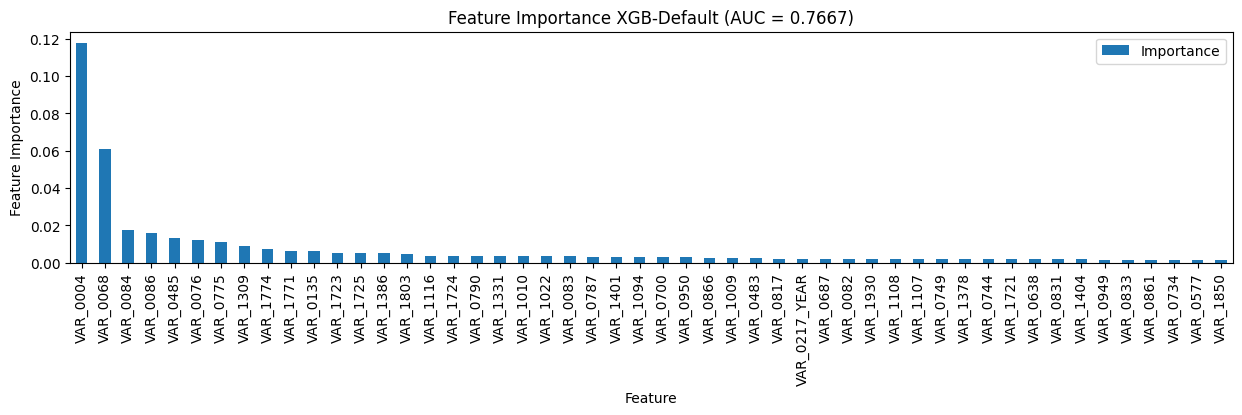

In [161]:
%%script skipped # Skipped for resource optimization

df_feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': clf_xgb_default.feature_importances_})
df_feat_imp = df_feat_imp.sort_values(by='Importance', ascending=False)
df_feat_imp[:50].plot(kind='bar',
                      x='Feature',
                      y='Importance',
                      title=f'Feature Importance XGB-Default (AUC = {mean_auc_val:.4f})',
                      xlabel='Feature',
                      ylabel='Feature Importance',
                      figsize=(15, 3))

In [162]:
%%script skipped # Skipped for resource optimization

top_feat_50 = df[df_feat_imp[:50]['Feature']]

cat_feat = top_feat_50.select_dtypes('object').columns
num_feat = top_feat_50.select_dtypes(exclude='object').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Numbers of categorical feature(s): 0
Numbers of numerical feature(s): 50


In [165]:
%%script skipped # Skipped for resource optimization

y_preds = clf_xgb_default.predict_proba(preprocessor_pipe.transform(X_test))[:, 1]
clf_xgb_def_auc_test = roc_auc_score(y_test, y_preds)

print(f'AUC score of test dataset: {clf_xgb_def_auc_test:.4f}')

AUC score of test dataset: 0.7683


##### **D. Tuned XGBoost**

In [232]:
defined_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'auc',
    'n_jobs': 2,
    'verbosity': 0,
    'seed': 42
  }

def objective(trial: Trial):
  tuned_params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 150),
    'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
    'reg_alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    'reg_lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True)
  }
  
  clf_lgbm_tuned = XGBClassifier(**defined_params, **tuned_params)
    
  auc_scores_train, auc_scores_valid = train_model(X, y,
                                                  model=clf_lgbm_tuned,
                                                  preprocessor=preprocessor,
                                                  scorer=roc_auc_score,
                                                  cv_fold=skf,
                                                  skip_fold='odd')
  mean_auc_train, mean_auc_valid = np.mean(auc_scores_train), np.mean(auc_scores_valid)

  print(f'Mean AUC oof score (n={trial.number}): {mean_auc_train:.4f} (train) | {mean_auc_valid:.4f} (valid)')
  
  return mean_auc_valid

def callback(study: Study, trial: Trial):
  joblib.dump(study, 'clf_xgb_study.pkl')

In [230]:
try:
  study = joblib.load('clf_xgb_study.pkl')
except FileNotFoundError:
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=50, n_jobs=1, callbacks=[callback])

[I 2024-01-04 14:05:09,892] A new study created in memory with name: no-name-b455c7c4-c351-4861-aef9-860820ba2a26
[I 2024-01-04 14:21:41,402] Trial 0 finished with value: 0.776593458470028 and parameters: {'n_estimators': 131, 'learning_rate': 0.003587101328581355, 'max_depth': 10, 'subsample': 0.7463126730905423, 'colsample_bytree': 0.5923657751529295, 'min_child_weight': 8, 'gamma': 0.14794780346803238, 'scale_pos_weight': 6.256595958032536, 'alpha': 0.005221030339231559, 'lambda': 3.0768427658763198}. Best is trial 0 with value: 0.776593458470028.


Mean AUC oof score (n=0): 0.8828 (train) | 0.7630 (valid)


[W 2024-01-04 14:23:00,602] Trial 1 failed with parameters: {'n_estimators': 72, 'learning_rate': 0.06594628011723067, 'max_depth': 15, 'subsample': 0.6008555049861386, 'colsample_bytree': 0.9992859349707622, 'min_child_weight': 8, 'gamma': 0.5900596689881614, 'scale_pos_weight': 1.8233170265714507, 'alpha': 0.6454182644043648, 'lambda': 0.17294984367120544} because of the following error: XGBoostError('[14:23:00] C:\\buildkite-agent\\builds\\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\\xgboost\\xgboost-ci-windows\\src\\common\\io.h:232: bad_malloc: Failed to allocate 3812220000 bytes.').
Traceback (most recent call last):
  File "C:\Users\msi.pc\AppData\Local\Temp\ipykernel_11372\2276697182.py", line 2, in <module>
    study = joblib.load('clf_xgb_study.pkl')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\msi.pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\numpy_pickle.py", line 650, in load
    with open(filename, 'rb') as f:
     

XGBoostError: [14:23:00] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 3812220000 bytes.